In [1]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [2]:
import pickle
import gensim
data = pickle.load(open("image_vectors.p", "rb"))
word_vector = pickle.load(open("word_vector_min_bird.p", "rb"))
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

11840
11840
Black_Footed_Albatross_0001_796111.jpg
Black_Footed_Albatross_0001_796111.jpg
Black_Footed_Albatross_0002_55.jpg
Black_Footed_Albatross_0003_796136.jpg
Black_Footed_Albatross_0005_796090.jpg
Black_Footed_Albatross_0006_796065.jpg
Black_Footed_Albatross_0007_796138.jpg
Black_Footed_Albatross_0008_796083.jpg
Black_Footed_Albatross_0009_34.jpg


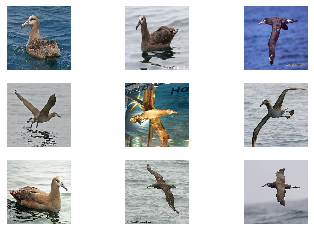

In [3]:

import matplotlib.pyplot as pyplot
from keras.preprocessing.image import array_to_img
from numpy import expand_dims
from random import randint, choice

def random_flip(image):
  image = tf.image.flip_left_right(image)
  return image.numpy()

def random_jitter(image):

  image = expand_dims(image, 0) #add additional dimension necessary for zooming
  image = image_augmentation_generator.flow(image, batch_size=1)
  result = image[0].reshape(image[0].shape[1:]) #remove additional dimension (1, 64, 64, 3) to (64, 64, 3)
  return result

image_augmentation_generator = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=[0.8, 1.0]) # random zoom proves to be helpful in capturing more details https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

n = 227
image_embeddings = []
captions = []
labels = []
for i, k in enumerate(data.keys()):
  image_embeddings.append(data[k])
  captions.append(word_vector[k])
  labels.append(k)
  if i % n == 0:
   image_embeddings.append(random_jitter(data[k]))
   captions.append(word_vector[k])
   labels.append(k)

print(len(captions))
print(len(image_embeddings))

pyplot.axis('off')
slcie = image_embeddings[40:50]
for i in range(9):
  pyplot.subplot(3, 3, i+1)
  pyplot.imshow(array_to_img(slcie[i]))
  print(labels[i])
  pyplot.axis('off')

pyplot.show()

In [4]:
import numpy as np

def get_random_word_vectors_from_dataset(n_samples):
  ix = np.random.randint(0, len(captions), n_samples)
  return np.asarray(captions)[ix]


In [5]:

def generate_random_vectors(n_samples):  
  vectorized_random_captions = []

  for n in range(n_samples):
    rnd = randint(8, 25)
    result_array = np.empty((0, 300))
    for i in range(rnd):
      result_array = np.append(result_array, [model[choice(model.index_to_key)]], axis=0)
    vectorized_random_captions.append(np.mean(result_array, axis=0).astype('float32'))

  return np.array(vectorized_random_captions)


In [38]:
from tensorflow.keras.layers import (Input, Conv2D, Activation,Dense, LeakyReLU,
Lambda, Multiply, Add,Concatenate, Reshape, UpSampling2D, BatchNormalization)

In [50]:
from keras.preprocessing.image import array_to_img

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy import asarray
import numpy as np

import os
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from numpy.random import random
from tensorflow.keras import layers
from tensorflow.keras import Model
from numpy.random import randn
from numpy.random import randint
import time
from keras.layers.advanced_activations import PReLU
from tensorflow.keras.utils import plot_model

# Discriminator model
def define_discriminator(Nphi, Nd, Md, imsize, layerSeq):
    phi_t = Input(shape=(Nphi,),name='embedding')
    img = Input(shape=imsize, name='input image')
    x1 = Dense(Nd, input_shape=phi_t.shape)(phi_t)
    
    # Replicating to Md x Md x Nd
    x1 = Reshape([1,1,Nd])(x1)
    x1 = UpSampling2D(input_shape=(1,1,Nd), size=(Md,Md))(x1)
    
    # Downsampling
    in_channels = imsize[2]
    sz = imsize[1]
    x0 = img
    for i in range(len(layerSeq)):
        out_channels = layerSeq[i]
        x0 = Conv2D(out_channels, 4, strides=(2,2), padding='same', input_shape=(sz,sz,in_channels))(x0)
        if i!=0:
            x0 = BatchNormalization()(x0)
        x0 = LeakyReLU()(x0)
        sz /= 2
    
    # Concatenate, and feed into 1x1 convolution layer
    x = Concatenate(axis=3)([x0, x1])
    in_channels = out_channels + Nd
    
    x = Conv2D(32, 1, input_shape=(Md, Md, in_channels))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Reshape([Md*Md*32])(x)
    x = Dense(1, input_shape=x.shape, activation='sigmoid')(x)
    model = Model(inputs=[phi_t, img], outputs=[x])
    return model


def resnet_block(model, kernel_size, filters, strides):
    gen = model
    model = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding="same")(model)
    model = layers.BatchNormalization(momentum=0.5)(model)
    model = tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(model)
    model = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding="same")(model)
    model = layers.BatchNormalization(momentum=0.5)(model)
    model = layers.Add()([gen, model])
    return model


# Generator model
def define_generator(Nphi=1024,Ng=128,Nz=100):
    kernel_init = tf.random_normal_initializer(stddev=0.02)
    batch_init = tf.random_normal_initializer(1., 0.02)

    Nx = Ng+Nz
    phi_t = Input(shape=(Nphi,),name='Embedding Input')
    eps = Input(shape=(Ng,),name='Conditioning Augmentation Input')
    z = Input(shape=(Nz,), name='Noise Input')
    
    # Conditioning Augmentation
    musigma = Dense(2*Ng, input_shape=phi_t.shape)(phi_t)
    musigma = LeakyReLU()(musigma)
    mu0 = Lambda(lambda x: x[:,0:Ng])(musigma)
    sigma0 = (Lambda(lambda x: x[:,Ng:])(musigma)) #logsigma
    sigma0 = Activation('exponential')(sigma0)
    tmp = Multiply()([eps, sigma0])
    c0 = Add()([mu0,tmp])
    
    # Making Generator0 Input
    x = Concatenate(axis=1)([c0, z])
    x = Dense(4*Nx, input_shape=x.shape)(x)
    x = Activation('relu')(x)
    x = Reshape([2,2,Nx])(x)
    
    # Code for Generator0 Model- Upsampling
    layerSeq0 = [256, 128, 64, 32, 3]
    in_channels = Nx
    sz = 2
    for i in range(len(layerSeq0)):
        sz = sz<<i
        t = sz<<1
        out_channels = layerSeq0[i]
        x = UpSampling2D(input_shape=(sz,sz,in_channels))(x)
        x = Conv2D(out_channels, 3, padding='same', input_shape=(t,t,in_channels))(x)
        if i < len(layerSeq0)-1:
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
        in_channels = out_channels
    x = Activation('tanh')(x)
    model = Model(inputs = [phi_t, eps, z], outputs = [x, musigma])
    return model

In [83]:
gen0 = define_generator()

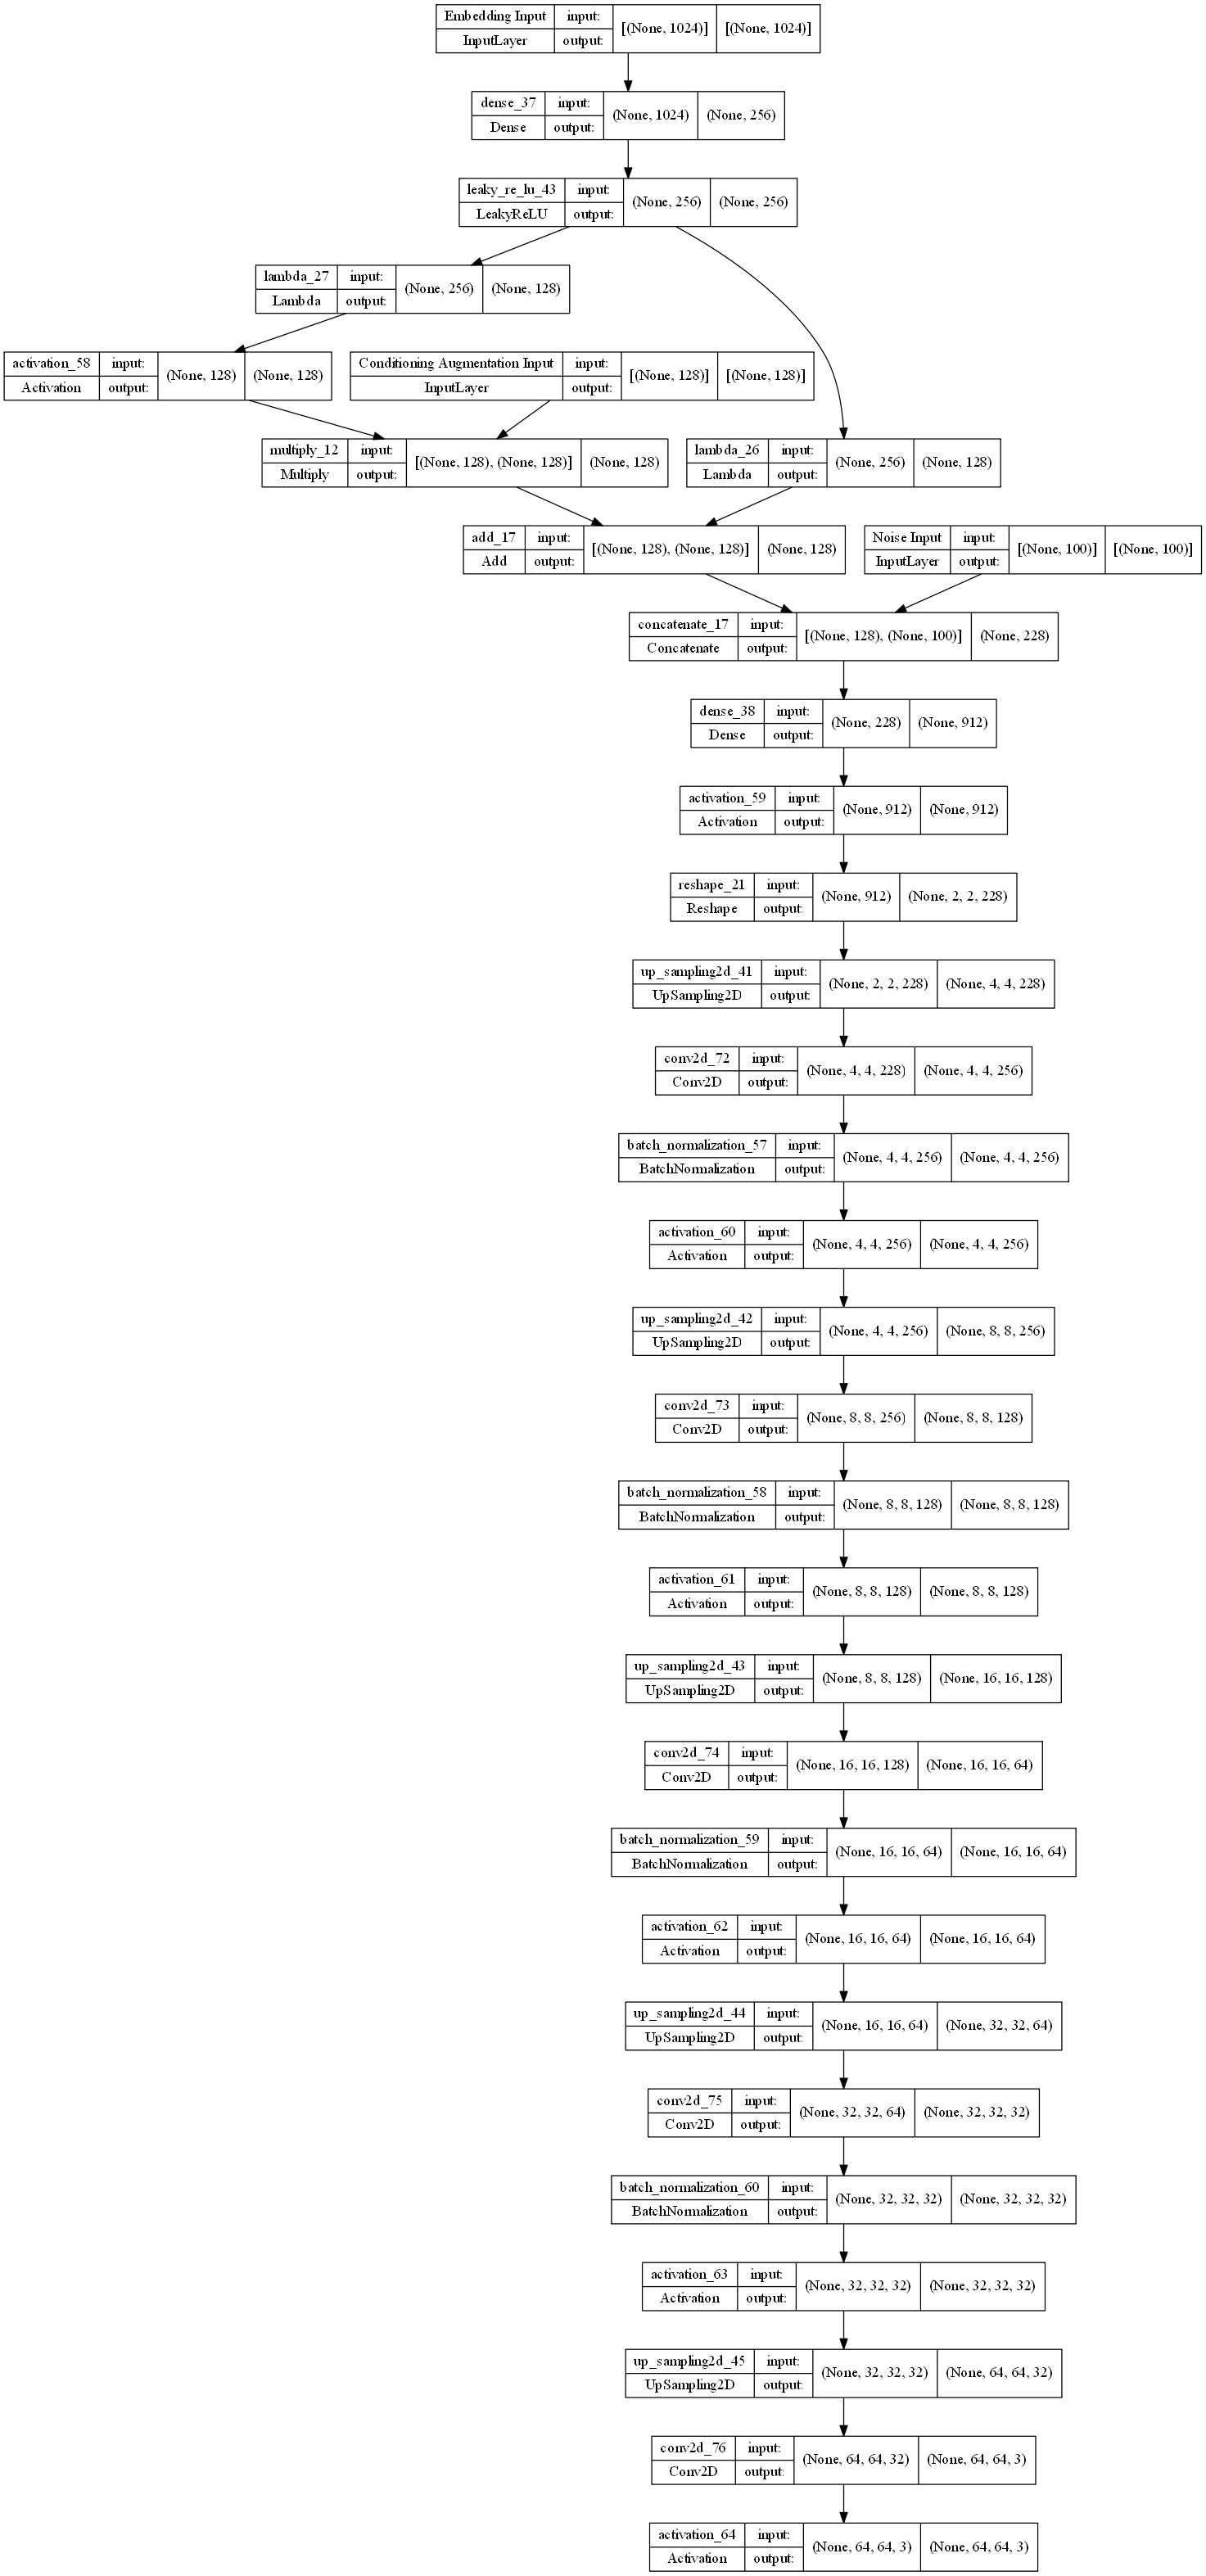

In [84]:
tf.keras.utils.plot_model(gen0,to_file="gen_model.png",show_shapes=True,dpi=92)

In [85]:
dc0 = define_discriminator(1024,128,4,(64,64,3),[64, 128, 256, 512])

In [86]:
def GAN0(gen, disc, Nphi, Ng, Nz):
    phi_t = Input(shape=(Nphi,))
    eps = Input(shape=(Ng,))
    z = Input(shape=(Nz,))
    disc.trainable = False
    gen_img, musigma = gen([phi_t, eps, z])
    isValid = disc([phi_t, gen_img])
    model= Model(inputs=[phi_t, eps, z], outputs=[isValid, musigma])
    return model

In [87]:
from IPython.display import clear_output


def generate_latent_points(latent_dim, n_samples):
    x_input  = tf.random.normal([n_samples, latent_dim])
    text_captions = get_random_word_vectors_from_dataset(n_samples)
    return [x_input, text_captions]

# Randomly flip some labels. Credits to https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/
def noisy_labels(y, p_flip):
    n_select = int(p_flip * int(y.shape[0]))
    flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)

    op_list = []
    for i in range(int(y.shape[0])):
        if i in flip_ix:
            op_list.append(tf.subtract(1.0, y[i]))
        else:
            op_list.append(y[i])

    outputs = tf.stack(op_list)
    return outputs

def load_data():
    return asarray(image_embeddings), asarray(captions).astype('float32')

def smooth_positive_labels(y):
	return y - 0.3 + (np.random.random(y.shape) * 0.5)
 
def smooth_negative_labels(y):
	return y + np.random.random(y.shape) * 0.3

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  print(predictions.shape)
  pyplot.figure(figsize=[7, 7])

  for i in range(predictions.shape[0]):
      pyplot.subplot(5, 5, i+1)
      pyplot.imshow(array_to_img(predictions.numpy()[i]))
      pyplot.axis('off')

  pyplot.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  pyplot.show()


def discriminator_loss(r_real_output_real_text, f_fake_output_real_text_1, f_real_output_fake_text):
   alpha = 0.5
   real_output_noise = smooth_positive_labels(noisy_labels(tf.ones_like(r_real_output_real_text), 0.10))
   fake_output_real_text_noise_1 = smooth_negative_labels(tf.zeros_like(f_fake_output_real_text_1))
   real_output_fake_text_noise = smooth_negative_labels(tf.zeros_like(f_real_output_fake_text))

   real_loss = tf.reduce_mean(binary_cross_entropy(real_output_noise, r_real_output_real_text))
   fake_loss_ms_1 = tf.reduce_mean(binary_cross_entropy(fake_output_real_text_noise_1, f_fake_output_real_text_1))
   fake_loss_2 = tf.reduce_mean(binary_cross_entropy(real_output_fake_text_noise, f_real_output_fake_text))

   total_loss = real_loss + alpha * fake_loss_2 + (1-alpha) * fake_loss_ms_1 
   return total_loss

def generator_loss(f_fake_output_real_text):
   return tf.reduce_mean(binary_cross_entropy(tf.ones_like(f_fake_output_real_text), f_fake_output_real_text))

from tqdm.notebook import tqdm
def train(dataset, epochs = 600):


  #checkpoint_dir = 'checkpoint'
  #checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  #checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
   #                             discriminator_optimizer=discriminator_optimizer,
    #                              generator=generator,
     #                             discriminator=discriminator)
  
  #ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
  #if ckpt_manager.latest_checkpoint:
   # checkpoint.restore(ckpt_manager.latest_checkpoint)  #ckpt_manager.checkpoints[3]
    #print ('Latest checkpoint restored!!')
    

    for epoch in range(epochs):
        rand_shuffle = np.arange(lenX)
        np.random.shuffle(rand_shuffle)
        X_real = X_real[rand_shuffle]
        Phi_t = Phi_t[rand_shuffle]
        d_loss = 0
        g_loss = [0, 0, 0]
        for j in tqdm(range(iterations)):
            i1 = j*batch_size
            i2 = i1 + batch_size
            x_real = X_real[i1:i2,:,:]
            phi_t = Phi_t[i1:i2,:]
            curr_size = int(tuple(x_real.shape)[0])
            d_size = curr_size<<1
            musigma_dummy = np.ones((curr_size,2*Ng))
            real_labels = np.ones((curr_size,1))*0.9
            false_labels = np.zeros((curr_size,1))

            # Now, get some wrong images
            i3 = (i2 + batch_size)
            if i2 >= lenX or i3 >lenX:
                i2 = 0
                i3 = curr_size    
            x_wrong = X_real[i2:i3,:,:]
            wrong_labels = np.zeros((curr_size,1))

            eps = np.random.normal(0, 1, [curr_size, Ng])
            z = np.random.normal(0, 1, [curr_size, Nz])
            x_false, musigma = gen0.predict([phi_t, eps, z])

            X = np.concatenate([x_real, x_false, x_wrong], axis = 0)
            Labels = np.concatenate([real_labels, false_labels, wrong_labels], axis=0)

            #shuff = np.arange(3*curr_size)
            #np.random.shuffle(shuff)
            #X = X[shuff]
            #Phi_t = Phi_t[shuff]
            #Labels = Labels[shuff]

            d_loss += dc0.train_on_batch([phi_t, X[0:curr_size]], [Labels[0:curr_size]])
            d_loss += dc0.train_on_batch([phi_t, X[curr_size:d_size]], [Labels[curr_size:d_size]])
            d_loss += dc0.train_on_batch([phi_t, X[d_size:]], [Labels[d_size:]])

            loss = gan0.train_on_batch([phi_t, eps, z], [real_labels, musigma_dummy])
            for k in range(len(loss)):
                g_loss[k] += loss[k]


            if ((j+1) % 30 == 0) or ((j+1) == iterations):
                d_loss /= 30
                for k in range(len(g_loss)):
                    g_loss[k] /= 30 
                print((i+1), (j+1), d_loss, g_loss)
                d_loss = 0
                g_loss = [0, 0, 0]
                #print('Memory Recollected-',gc.collect())

        gen0.save_weights(gen_loc)
        dc0.save_weights(dis_loc)
        if (i+1)%100 == 0:
            learning_rate /= 2
            K.set_value(dc0.optimizer.lr, learning_rate)
            K.set_value(gan0.optimizer.lr, learning_rate)
            print('The Learning Rate Now is:', K.get_value(dc0.optimizer.lr))
        if (i+1)%10 == 0:
            emb = testEmb[:,random.randint(0, testEmb.shape[1]-1),:]
            eps = np.random.normal(0, 1, [testEmb.shape[0], Ng])
            z = np.random.normal(0, 1, [testEmb.shape[0], Nz])
            x_test, _ = gen0.predict([emb, eps, z])
            x_test = 127.5*(x_test + 1)
            for k in range(x_test.shape[0]):
                cv2.imwrite('ResultsI_2\\'+str(k)+'.jpg', x_test[k])




In [88]:
from tensorflow.keras.optimizers import Adam

In [93]:
import random
import numpy as np
import time
#from loadData import *
#from modelsGAN import *
import cv2
Nphi = 1024
Ng = 128
Nz = 100
Nd = 128
Nx = Ng+Nz
Md = 4
Mg = 16
Nres = 4
batch_size = 64
epochs = 600
start_epoch = 0
learning_rate = 0.0002
gen_loc = 'Generator0_5_2a.h5'
dis_loc = 'Discriminator0_5_2a.h5'
random.seed(time.time())
np.random.seed(int(time.time()+0.5))

In [94]:
start_epoch = 0
m = start_epoch//100
learning_rate = 0.0002/(1<<m)
dis_optimizer = Adam(lr=learning_rate, beta_1=0.5)
gen_optimizer = Adam(lr=learning_rate, beta_1=0.5)
dc0.compile(dis_optimizer, loss=['binary_crossentropy'])
gan0 = GAN0(gen0, dc0, Nphi, Ng, Nz)
gan0.compile(gen_optimizer, loss=['binary_crossentropy', KL_loss], loss_weights=[1,1], metrics=None)

print('Loading Dataset...')
X_real, Emb, _ = load_dataset('birds/train/', 'CUB_200_2011/', 64)
X_real = (X_real-127.5)/127.5

testEmb, c_, d_ = extract_aux_info('birds/test/')
print('Embeddings:', Emb.shape,'CUB Dataset:', X_real.shape)

lenX = X_real.shape[0]
iterations = 1+(lenX//batch_size)
Phi_t = np.zeros((lenX, Nphi))
for i in range(lenX):
    Phi_t[i] += Emb[i,random.randint(0, Emb.shape[1]-1),:]

NameError: name 'KL_loss' is not defined

In [73]:
ms_loss_weight = 1.0
import tensorflow as tf
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.000035, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.000035, beta_1 = 0.5)

discriminator = define_discriminator(1024,128,4,(64,64,3),[64, 128, 256, 512])
generator = define_generator()

images, lbs = load_data()
BUFFER_SIZE = images.shape[0]
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((images,lbs)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#train(train_dataset)

In [74]:
train(train_dataset)

NameError: name 'lenX' is not defined

In [58]:
#
from keras.preprocessing.image import array_to_img

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy import asarray
import numpy as np

import os
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from numpy.random import random
from tensorflow.keras import layers
from tensorflow.keras import Model
from numpy.random import randn
from numpy.random import randint
import time
import matplotlib.pyplot as pyplot
from keras.preprocessing.image import array_to_img
from numpy import linspace
import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize

from numpy.random import randint
import numpy as np

def create_sent_vector(sent):
  result_array = np.empty((0, 300))

  for word in word_tokenize(sent):
    result_array = np.append(result_array, [model[word]], axis=0)
  final = np.mean(result_array, axis=0).astype('float32')
  return final

def generate_random_word_vectors_from_dataset(n_samples, create_new_captions = False):

  if create_new_captions:
      e = create_sent_vector('This bird has  white breast with brown feathers')
      f = create_sent_vector('This bird has  white breast with blue feathers')
      v = []
      flag = False
      for i in range(n_samples):
        
        if not flag:
          v.append(f)
          flag = True
        elif flag:
          v.append(e)
          flag = False
      return np.asarray(v), np.asarray([])
  else:
    ix = randint(0,len(captions), n_samples)
    print(ix)
    return  np.asarray(captions)[ix], np.asarray(labels)[ix]

def generate_images(model, test_input):

  predictions = model(test_input, training=False)

  print(predictions.shape)
  pyplot.figure(figsize=[15, 15])
  for i in range(predictions.shape[0]):
      pyplot.subplot(1, 9, i+1)
      pyplot.imshow(array_to_img(predictions.numpy()[i]))
      pyplot.axis('off')

  pyplot.show()

# Credit to: https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/
def interpolate_points(p1, p2, n_steps=9):
	ratios = linspace(0, 1, num=n_steps)
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return np.asarray(vectors)
 
def generate_latent_points(latent_dim, n_samples, interpolate = False):
    x_input  = tf.random.normal([n_samples, latent_dim])
    text_captions, labels = generate_random_word_vectors_from_dataset(n_samples, create_new_captions=False)
    if interpolate:
      text_captions = interpolate_points(text_captions[0], text_captions[1])
      x_input = interpolate_points(x_input[0], x_input[1])
    for index, s in enumerate(labels.flat):
      print(index, s)

    return [x_input, text_captions]

gen_model = tf.keras.models.load_model('/content/drive/My Drive/146stage_new_gan_animal_model_120.h5')

for i in range(40):
  generate_images(gen_model, generate_latent_points(100, 9))


OSError: No file or directory found at /content/drive/My Drive/146stage_new_gan_animal_model_120.h5

In [59]:
train(train_dataset,epochs=1135)

ValueError: Shapes (64,) and (12288,) are incompatible

In [284]:
def get_index_by_label(label):
  for idx, l in enumerate(labels):
    if l in label:
      return idx


print(get_index_by_label('Western_Wood_Pewee_0061_795060.jpg'))

5987


(-0.5, 63.5, 63.5, -0.5)

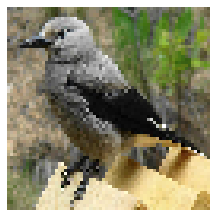

In [285]:
# Show image in image embeddings

pyplot.figure(figsize=[8, 8])

pyplot.subplot(1, 2, 0+1)
pyplot.imshow(array_to_img(image_embeddings[5432]))
pyplot.axis('off')

In [286]:
import tensorflow as tf
gen_model = tf.keras.models.load_model('models/46stage_new_gan_animal_model_781.h5')

In [287]:
import numpy as np
def get_random_word_vectors_from_dataset(n_samples,captions):
    ix = np.random.randint(0, len(captions), n_samples)
    return np.asarray(captions)[ix]

In [296]:
def de7ko(cap):
    f = create_sent_vector(cap)
    v = []
    flag = False
    for i in range(1):    
        v.append(f)
        flag = True
    return np.asarray(v), np.asarray([])

In [297]:
noise = tf.random.normal((1,100))

In [303]:
caption, _ = de7ko('This bird is medium sized has white feather')

In [304]:
print(noise.shape)

(1, 100)


In [305]:
predictions = gen_model([noise,caption], training=False)

In [306]:
predictions.shape

TensorShape([1, 64, 64, 3])

(-0.5, 63.5, 63.5, -0.5)

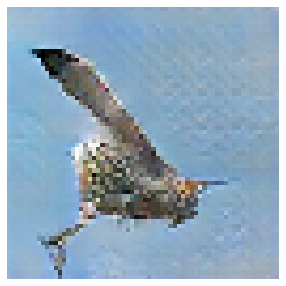

In [309]:
pyplot.figure(figsize=[5, 5])

pyplot.imshow(array_to_img(predictions.numpy()[i]))
pyplot.axis('off')

In [500]:
from gensim.parsing.preprocessing import remove_stopwords

In [501]:
import string

In [502]:
from gensim.parsing.preprocessing import STOPWORDS

all_stopwords_gensim = STOPWORDS.union(set(['a']))

In [562]:
def make_prediction(cap):
    text = cap
    cap = remove_stopwords(text)
    cap = cap.translate(str.maketrans('','', string.punctuation))
    noise = tf.random.normal((1,100))
    
    caption, _ = de7ko(cap)
    predictions = gen_model([noise,caption], training=False)
    pyplot.figure(figsize=[5, 5])
    pyplot.imshow(array_to_img(predictions.numpy()[i]))
    pyplot.axis('off')

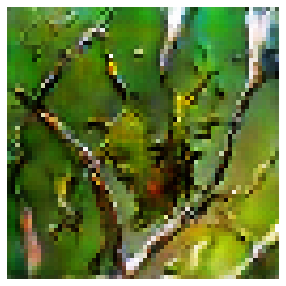

In [592]:
make_prediction('yellow bird')

In [131]:
# First + Second - Third
model.most_similar_cosmul(positive=['Eminem','Egypt'],negative=['USA'])

[('President_Hosni_Mubarak', 0.994341254234314),
 ('rapper_Eminem', 0.9719358682632446),
 ('Jay_Z', 0.963207483291626),
 ('Tamer_Hosni', 0.9619079232215881),
 ('Kanye', 0.9590561985969543),
 ('Mubarak', 0.954376220703125),
 ('Amr_Diab', 0.950806736946106),
 ('Abdel_Halim_Hafez', 0.9416908621788025),
 ('Hosni_Mubarak', 0.9397608041763306),
 ('Cent', 0.9366979598999023)]